# Car Damage Prediction Project

#### Import Libraries and set the device

In [27]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import torchvision.models as models
from matplotlib import pyplot as plt
import optuna

In [2]:
import torch

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)


mps


### Load Data

In [3]:
image_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
import shutil
ipynb_path = os.path.join("dataset", ".ipynb_checkpoints")
if os.path.exists(ipynb_path):
    shutil.rmtree(ipynb_path)

In [5]:
dataset_path = "dataset"
dataset = datasets.ImageFolder(dataset_path,transform=image_transforms)
len(dataset)
                              

2300

In [39]:
class_names = dataset.classes

In [6]:
num_classes = len(dataset.classes)
num_classes

6

In [7]:
train_size = int(0.75*len(dataset))
val_size  = len(dataset)-train_size
train_size,val_size

(1725, 575)

In [8]:
train_dataset, val_dataset = random_split(dataset,[train_size,val_size])

In [9]:
train_dataloader = DataLoader(train_dataset,batch_size=32,shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size=32,shuffle=True)

In [10]:
for images, labels in train_dataloader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [11]:
img = images[0]

In [12]:
img.shape

torch.Size([3, 224, 224])

In [13]:
img.permute(1,2,0).shape

torch.Size([224, 224, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.5702832].


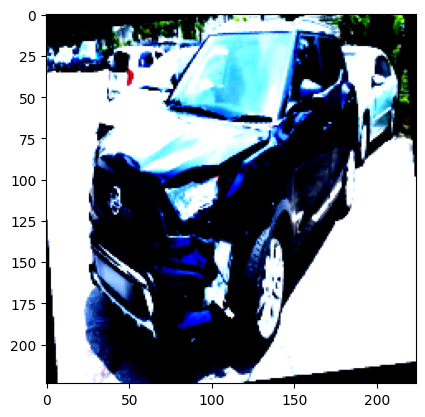

In [14]:
plt.imshow(img.permute(1,2,0))
plt.show()

### Model 1: CNN

In [15]:
class CarClassifierCNN(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,stride=1,padding=1), # (3,224,224) -> (16,224,224)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0), #(16,224,224)->(16,112,112)

            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1), # (16,224,224) -> (32,224,224)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0), #(32,112,112)->(32,56,56)

            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1), # (32,56,56) -> (64,56,56)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0), #(64,56,56)->(64,28,28)

            nn.Flatten(),

            nn.Linear(64*28*28,512),
            nn.ReLU(),

            nn.Linear(512,num_classes)  
        )

    def forward(self,x):
        x = self.network(x)
        return x

In [16]:
model = CarClassifierCNN(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

In [17]:
def train_model(model,criterion,optimizer,epochs=5):
    start = time.time()
    for epoch in range(epochs):
        model.train()
        running_loss=0.0
        losses = []
        for batch_num, (images,labels) in enumerate(train_dataloader):
            images,labels = images.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()
            #forward pass
            outputs = model(images)
            loss = criterion(outputs,labels)

            #backward pass
            loss.backward()
            optimizer.step()

            running_loss+=loss.item() * images.size(0)  # images.size(0)=batchsize -> this gives loss of a batch
            losses.append(loss.item())
            if (batch_num+1) % 10 == 0:
                print(f"Batch: {batch_num+1}, Epoch: {epoch+1}, Loss: {loss.item():0.2f}")
            

        epoch_loss = running_loss/len(train_dataloader.dataset)
        my_epoch_loss = sum(losses) / len(losses)
        
        print(f"Epoch [{epoch+1}/{epochs}], Avg Loss: {epoch_loss:.4f}, trainloader size:{len(train_dataloader.dataset)}, my loss: {my_epoch_loss}")



        model.eval()
        correct=0
        total=0
        all_labels=[]
        all_predictions=[]
        with torch.no_grad():
            for images, labels in val_dataloader:
                images, label = images.to(device), labels.to(device)
                outputs=model(images)
                _,predicted = torch.max(outputs.data,1)
                total += labels.size(0)
                correct += (predicted == labels.to(device)).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())
                
            print(f"*** Validation Accuracy: {100 * correct / total:.2f}% ***")
            
    end = time.time()
    print(f"Execution time: {end - start} seconds")     
    
    return all_labels, all_predictions

In [18]:
model = CarClassifierCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.80
Batch: 20, Epoch: 1, Loss: 1.79
Batch: 30, Epoch: 1, Loss: 1.75
Batch: 40, Epoch: 1, Loss: 1.52
Batch: 50, Epoch: 1, Loss: 1.45
Epoch [1/10], Avg Loss: 2.1266, trainloader size:1725, my loss: 2.1256599073056823
*** Validation Accuracy: 45.39% ***
Batch: 10, Epoch: 2, Loss: 1.24
Batch: 20, Epoch: 2, Loss: 1.69
Batch: 30, Epoch: 2, Loss: 1.46
Batch: 40, Epoch: 2, Loss: 1.27
Batch: 50, Epoch: 2, Loss: 1.12
Epoch [2/10], Avg Loss: 1.4459, trainloader size:1725, my loss: 1.4451970413879112
*** Validation Accuracy: 49.91% ***
Batch: 10, Epoch: 3, Loss: 1.23
Batch: 20, Epoch: 3, Loss: 1.41
Batch: 30, Epoch: 3, Loss: 1.16
Batch: 40, Epoch: 3, Loss: 1.17
Batch: 50, Epoch: 3, Loss: 1.30
Epoch [3/10], Avg Loss: 1.1732, trainloader size:1725, my loss: 1.1730660752013877
*** Validation Accuracy: 54.61% ***
Batch: 10, Epoch: 4, Loss: 1.00
Batch: 20, Epoch: 4, Loss: 1.18
Batch: 30, Epoch: 4, Loss: 0.96
Batch: 40, Epoch: 4, Loss: 0.91
Batch: 50, Epoch: 4, Loss: 1.06
Epo

### Model 2: CNN with Regularization

In [19]:
class CarClassifierCNNWithRegularization(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), # (16, 224, 224) 
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (16, 112, 112)
            
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (32, 56, 56)    
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (64, 28, 28)
            
            nn.Flatten(),
            
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.network(x)
        return x

In [20]:
model = CarClassifierCNNWithRegularization(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

all_labels, all_predictions = train_model(model, criterion, optimizer,  epochs=10)

Batch: 10, Epoch: 1, Loss: 8.94
Batch: 20, Epoch: 1, Loss: 4.63
Batch: 30, Epoch: 1, Loss: 3.05
Batch: 40, Epoch: 1, Loss: 1.36
Batch: 50, Epoch: 1, Loss: 1.64
Epoch [1/10], Avg Loss: 7.5781, trainloader size:1725, my loss: 7.567383236355251
*** Validation Accuracy: 46.96% ***
Batch: 10, Epoch: 2, Loss: 1.57
Batch: 20, Epoch: 2, Loss: 1.68
Batch: 30, Epoch: 2, Loss: 1.39
Batch: 40, Epoch: 2, Loss: 1.24
Batch: 50, Epoch: 2, Loss: 1.43
Epoch [2/10], Avg Loss: 1.3353, trainloader size:1725, my loss: 1.3350319972744695
*** Validation Accuracy: 52.17% ***
Batch: 10, Epoch: 3, Loss: 1.40
Batch: 20, Epoch: 3, Loss: 1.38
Batch: 30, Epoch: 3, Loss: 1.21
Batch: 40, Epoch: 3, Loss: 1.02
Batch: 50, Epoch: 3, Loss: 1.08
Epoch [3/10], Avg Loss: 1.2398, trainloader size:1725, my loss: 1.2395566194145768
*** Validation Accuracy: 54.78% ***
Batch: 10, Epoch: 4, Loss: 0.95
Batch: 20, Epoch: 4, Loss: 1.15
Batch: 30, Epoch: 4, Loss: 1.27
Batch: 40, Epoch: 4, Loss: 1.19
Batch: 50, Epoch: 4, Loss: 1.21
Epoc

### Model 3: Transfer Learning with EfficientNet

In [21]:
class CarClassifierEfficientNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.efficientnet_b0(weights='DEFAULT')
        
        # Freeze all layers except the final fully connected layer
        for param in self.model.parameters():
            param.requires_grad = False
        
        in_features = self.model.classifier[1].in_features
        
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, num_classes)
        )
        
    def forward(self, x):
        x = self.model(x)
        return x           

In [22]:
model = CarClassifierEfficientNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001) #optimise only the parameters that needs gradient computation

all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.73
Batch: 20, Epoch: 1, Loss: 1.57
Batch: 30, Epoch: 1, Loss: 1.50
Batch: 40, Epoch: 1, Loss: 1.13
Batch: 50, Epoch: 1, Loss: 1.26
Epoch [1/10], Avg Loss: 1.4590, trainloader size:1725, my loss: 1.4586594038539462
*** Validation Accuracy: 60.87% ***
Batch: 10, Epoch: 2, Loss: 1.20
Batch: 20, Epoch: 2, Loss: 1.13
Batch: 30, Epoch: 2, Loss: 1.09
Batch: 40, Epoch: 2, Loss: 1.07
Batch: 50, Epoch: 2, Loss: 1.12
Epoch [2/10], Avg Loss: 1.1394, trainloader size:1725, my loss: 1.1396016445424821
*** Validation Accuracy: 63.48% ***
Batch: 10, Epoch: 3, Loss: 0.91
Batch: 20, Epoch: 3, Loss: 0.79
Batch: 30, Epoch: 3, Loss: 0.78
Batch: 40, Epoch: 3, Loss: 0.88
Batch: 50, Epoch: 3, Loss: 1.07
Epoch [3/10], Avg Loss: 1.0147, trainloader size:1725, my loss: 1.0146608374736927
*** Validation Accuracy: 68.17% ***
Batch: 10, Epoch: 4, Loss: 0.72
Batch: 20, Epoch: 4, Loss: 0.86
Batch: 30, Epoch: 4, Loss: 1.05
Batch: 40, Epoch: 4, Loss: 0.93
Batch: 50, Epoch: 4, Loss: 0.95
Epo

### Model 4: Transfer Learning with ResNet

In [23]:
# Load the pre-trained ResNet model
class CarClassifierResNet(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')
        
        # Freeze all layers except the final fully connected layer
        for param in self.model.parameters():
            param.requires_grad = False
            
        # Unfreeze layer4 and fc layers
        for param in self.model.layer4.parameters():
            param.requires_grad = True            
            
        # Replace the final fully connected layer
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.model.fc.in_features, num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [24]:
model = CarClassifierResNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

labels, predictions = train_model(model, criterion, optimizer, epochs=10)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /Users/neethu/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████████████████████████████████| 97.8M/97.8M [00:07<00:00, 12.9MB/s]


Batch: 10, Epoch: 1, Loss: 1.12
Batch: 20, Epoch: 1, Loss: 0.79
Batch: 30, Epoch: 1, Loss: 0.59
Batch: 40, Epoch: 1, Loss: 0.76
Batch: 50, Epoch: 1, Loss: 1.10
Epoch [1/10], Avg Loss: 0.8818, trainloader size:1725, my loss: 0.8811111505384799
*** Validation Accuracy: 75.48% ***
Batch: 10, Epoch: 2, Loss: 0.33
Batch: 20, Epoch: 2, Loss: 0.38
Batch: 30, Epoch: 2, Loss: 0.25
Batch: 40, Epoch: 2, Loss: 0.75
Batch: 50, Epoch: 2, Loss: 0.65
Epoch [2/10], Avg Loss: 0.4781, trainloader size:1725, my loss: 0.4779764985044797
*** Validation Accuracy: 78.61% ***
Batch: 10, Epoch: 3, Loss: 0.34
Batch: 20, Epoch: 3, Loss: 0.44
Batch: 30, Epoch: 3, Loss: 0.30
Batch: 40, Epoch: 3, Loss: 0.35
Batch: 50, Epoch: 3, Loss: 0.38
Epoch [3/10], Avg Loss: 0.3344, trainloader size:1725, my loss: 0.33421069714758134
*** Validation Accuracy: 78.96% ***
Batch: 10, Epoch: 4, Loss: 0.27
Batch: 20, Epoch: 4, Loss: 0.14
Batch: 30, Epoch: 4, Loss: 0.32
Batch: 40, Epoch: 4, Loss: 0.08
Batch: 50, Epoch: 4, Loss: 0.32
Ep

### Hyperparameter Tuning

In [33]:
# Define the objective function for Optuna
def objective(trial):
    # Suggest values for the hyperparameters
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.7)
    
    # Load the model
    model = CarClassifierResNet(num_classes=num_classes, dropout_rate=dropout_rate).to(device)
    
    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    
    # Training loop (using fewer epochs for faster hyperparameter tuning)
    epochs = 3
    start = time.time()
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_num, (images, labels) in enumerate(train_dataloader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        
        # Validation loop
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_dataloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        
        # Report intermediate result to Optuna
        trial.report(accuracy, epoch)
        
        # Handle pruning (if applicable)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    end = time.time()
    print(f"Execution time: {end - start} seconds")
    
    return accuracy

In [34]:
# Create the study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

[I 2025-03-24 22:21:25,929] A new study created in memory with name: no-name-52265b82-2b3d-430e-8c01-b9eb7c749765
[I 2025-03-24 22:26:08,672] Trial 0 finished with value: 78.78260869565217 and parameters: {'lr': 0.00036237500879311463, 'dropout_rate': 0.6106701671282844}. Best is trial 0 with value: 78.78260869565217.


Execution time: 275.549711227417 seconds


[I 2025-03-24 22:31:22,364] Trial 1 finished with value: 77.3913043478261 and parameters: {'lr': 0.0001528315480713554, 'dropout_rate': 0.31027771472190546}. Best is trial 0 with value: 78.78260869565217.


Execution time: 313.0008051395416 seconds


[I 2025-03-24 22:39:53,002] Trial 2 finished with value: 69.04347826086956 and parameters: {'lr': 3.3726666407719794e-05, 'dropout_rate': 0.629450296140038}. Best is trial 0 with value: 78.78260869565217.


Execution time: 509.9529790878296 seconds


[I 2025-03-24 22:48:50,593] Trial 3 finished with value: 79.82608695652173 and parameters: {'lr': 0.00018586171670472728, 'dropout_rate': 0.283203813809928}. Best is trial 3 with value: 79.82608695652173.


Execution time: 536.7192740440369 seconds


[I 2025-03-24 22:58:30,728] Trial 4 finished with value: 74.6086956521739 and parameters: {'lr': 0.004395544040113425, 'dropout_rate': 0.3065437252472715}. Best is trial 3 with value: 79.82608695652173.


Execution time: 579.3023180961609 seconds


[I 2025-03-24 23:02:26,035] Trial 5 pruned. 
[I 2025-03-24 23:05:59,792] Trial 6 pruned. 
[I 2025-03-24 23:13:08,800] Trial 7 pruned. 
[I 2025-03-24 23:22:56,730] Trial 8 finished with value: 77.04347826086956 and parameters: {'lr': 0.001167355413120434, 'dropout_rate': 0.2524336216534859}. Best is trial 3 with value: 79.82608695652173.


Execution time: 585.545590877533 seconds


[I 2025-03-24 23:33:33,465] Trial 9 finished with value: 78.78260869565217 and parameters: {'lr': 0.0035405659311887132, 'dropout_rate': 0.6360245273908288}. Best is trial 3 with value: 79.82608695652173.


Execution time: 635.1294829845428 seconds


[I 2025-03-24 23:36:44,842] Trial 10 pruned. 
[I 2025-03-24 23:40:10,236] Trial 11 pruned. 
[I 2025-03-24 23:50:46,091] Trial 12 finished with value: 78.78260869565217 and parameters: {'lr': 0.0003424673191062632, 'dropout_rate': 0.41817172867316965}. Best is trial 3 with value: 79.82608695652173.


Execution time: 634.0062141418457 seconds


[I 2025-03-25 00:00:20,865] Trial 13 finished with value: 77.21739130434783 and parameters: {'lr': 0.0010336444961570406, 'dropout_rate': 0.20412959513498924}. Best is trial 3 with value: 79.82608695652173.


Execution time: 573.842288017273 seconds


[I 2025-03-25 00:02:58,195] Trial 14 pruned. 
[I 2025-03-25 00:05:36,664] Trial 15 pruned. 
[I 2025-03-25 00:23:27,889] Trial 16 pruned. 
[I 2025-03-25 00:26:22,629] Trial 17 pruned. 
[I 2025-03-25 01:31:16,102] Trial 18 finished with value: 74.08695652173913 and parameters: {'lr': 0.0019252190150146886, 'dropout_rate': 0.36141769948802965}. Best is trial 3 with value: 79.82608695652173.


Execution time: 3892.9494099617004 seconds


[I 2025-03-25 01:48:00,942] Trial 19 pruned. 


In [38]:
study.best_params

{'lr': 0.00018586171670472728, 'dropout_rate': 0.283203813809928}

In [ ]:
#### Using hyperparameter tuning, we figured that the best parameters for resnet models are (1) Dropout rate = 0.2 (2) Learning Rate = 0.0001. So now let's train the model once again with these best parameters

In [43]:
model = CarClassifierResNet(num_classes=num_classes, dropout_rate=0.2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)

labels, predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.73
Batch: 20, Epoch: 1, Loss: 1.54
Batch: 30, Epoch: 1, Loss: 1.20
Batch: 40, Epoch: 1, Loss: 1.18
Batch: 50, Epoch: 1, Loss: 1.02
Epoch [1/10], Avg Loss: 1.3865, trainloader size:1725, my loss: 1.3858161999119654
*** Validation Accuracy: 70.61% ***
Batch: 10, Epoch: 2, Loss: 0.77
Batch: 20, Epoch: 2, Loss: 0.76
Batch: 30, Epoch: 2, Loss: 0.71
Batch: 40, Epoch: 2, Loss: 0.54
Batch: 50, Epoch: 2, Loss: 0.66
Epoch [2/10], Avg Loss: 0.6736, trainloader size:1725, my loss: 0.6736456807012912
*** Validation Accuracy: 76.52% ***
Batch: 10, Epoch: 3, Loss: 0.54
Batch: 20, Epoch: 3, Loss: 0.31
Batch: 30, Epoch: 3, Loss: 0.40
Batch: 40, Epoch: 3, Loss: 0.68
Batch: 50, Epoch: 3, Loss: 0.48
Epoch [3/10], Avg Loss: 0.4609, trainloader size:1725, my loss: 0.46106180272720476
*** Validation Accuracy: 76.87% ***
Batch: 10, Epoch: 4, Loss: 0.27
Batch: 20, Epoch: 4, Loss: 0.41
Batch: 30, Epoch: 4, Loss: 0.25
Batch: 40, Epoch: 4, Loss: 0.21
Batch: 50, Epoch: 4, Loss: 0.58
Ep

### Model Evaluation using Confusion Matrix and Classification Report

In [44]:
from sklearn.metrics import classification_report

report = classification_report(labels, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.87      0.79      0.83       127
           1       0.68      0.84      0.75        93
           2       0.92      0.89      0.90       135
           3       0.89      0.68      0.77        74
           4       0.55      0.75      0.64        61
           5       0.85      0.75      0.80        85

    accuracy                           0.80       575
   macro avg       0.79      0.78      0.78       575
weighted avg       0.82      0.80      0.80       575



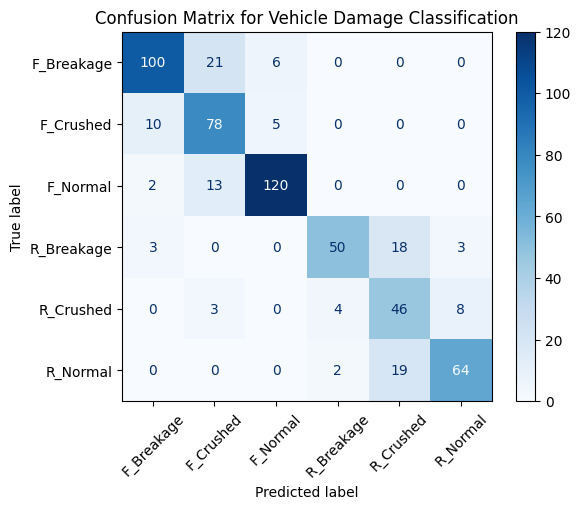

In [45]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

conf_matrix = confusion_matrix(labels, predictions, labels=np.arange(num_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix for Vehicle Damage Classification")
plt.show()

### Save the model

In [46]:
torch.save(model.state_dict(), 'saved_model.pth')